In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Known data association

In [2]:
def generate_data(num, R = np.eye(2), t = np.zeros([2,1])):
    data = np.zeros([2,num])
    data[0,:] = range(num)
    data[1,:] = 0.2 * data[0,:] * np.sin(0.5 * data[0,:])
    data = R @ data + t
    return data

def plot_data(data1, data2, data1_label = 'data1', data2_label = 'data2', pt_size1 = 6, pt_size2 = 6):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.plot(data1[0], data1[1], color='blue', marker='o', linestyle=":", label= data1_label, markersize = pt_size1)
    ax.plot(data2[0], data2[1], color='red', marker='o', linestyle=":", label= data2_label, markersize = pt_size2)
    ax.legend()
    return ax

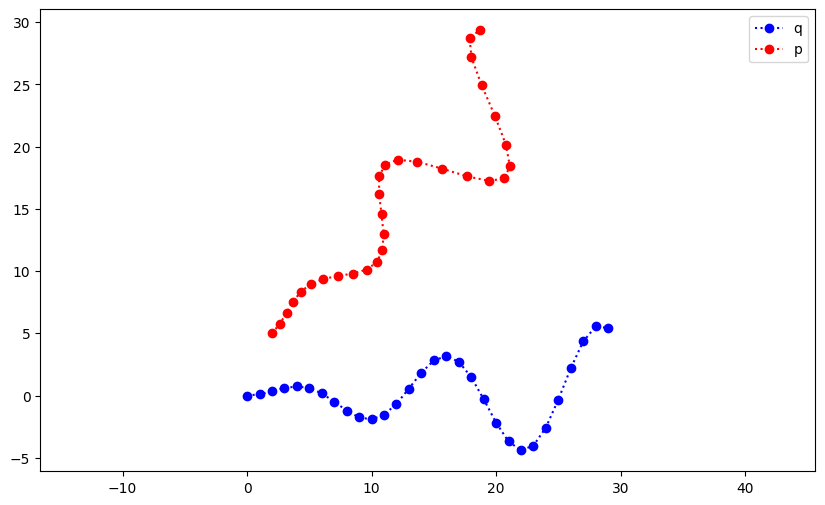

In [3]:
# generate data
num = 30
angle = np.pi / 4
R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
T = np.array([[2],[5]])

p = generate_data(num, R, T)
q = generate_data(num)

ax = plot_data(q, p, 'q', 'p')
plt.show()

# rotation and translation from p to q
true_R = R.transpose()
true_T = -T

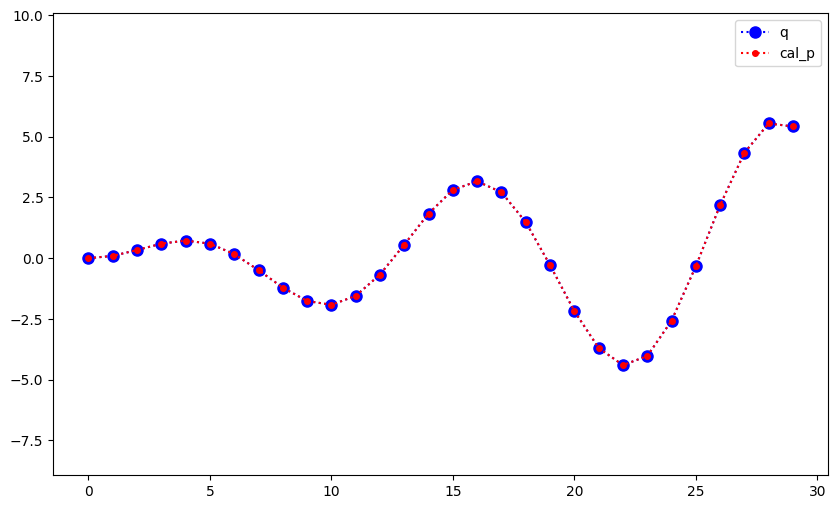

In [4]:
# equal weights pn
pn = np.ones(num)

p0 = np.zeros([2,1])
p0[0, 0] = (p[0, :] * pn).sum() / pn.sum()
p0[1, 0] = (p[1, :] * pn).sum() / pn.sum()

q0 = np.zeros([2,1])
q0[0, 0] = (q[0, :] * pn).sum() / pn.sum()
q0[1, 0] = (q[1, :] * pn).sum() / pn.sum()

H = np.zeros([2,2])
for i in range(num):
    b = q[:,i] - q0[:,0]
    a = p[:,i] - p0[:,0]
    H += np.outer(a, b) * pn[i]
    
u, s, vh = np.linalg.svd(H)

cal_R = (u @ vh).transpose()
cal_t = q0 - cal_R @ p0

# now shift p by cal_R and cal_t
cal_p = cal_R @ p + cal_t

ax = plot_data(q, cal_p, 'q', 'cal_p', 8, 4)
plt.show()

# 2. Unkown data association

### Closest points (Vanilla ICP)

In [5]:
def centralize(p, q):
    # get center
    p0 = np.zeros([2,1])
    p0[0,0] = p[0, :].sum() / p.shape[1]
    p0[1,0] = p[1, :].sum() / p.shape[1]
    
    q0 = np.zeros([2,1])
    q0[0,0] = q[0, :].sum() / q.shape[1]
    q0[1,0] = q[1, :].sum() / q.shape[1]
    
    # move p to center of q
    p = p - p0 + q0
    return p

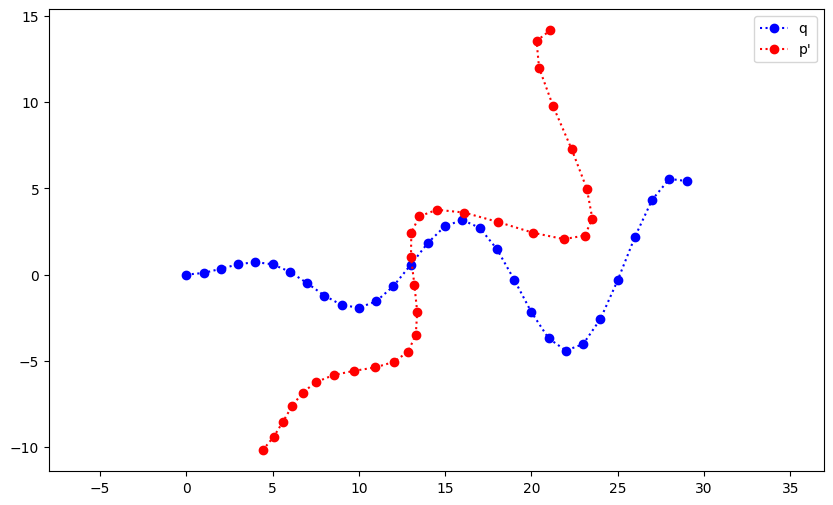

In [6]:
new_p = centralize(p,q)
ax = plot_data(q, new_p, 'q', "p'")
plt.show()

In [7]:
def get_l2Norm(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def find_closest_pair(p, q):
    pair = []
    for i in range(p.shape[1]):
        min_norm = np.inf
        correspond_id = -1
        for j in range(q.shape[1]):
            norm = get_l2Norm(p[:,i], q[:,j])
            if norm < min_norm:
                min_norm = norm
                correspond_id = j
        pair.append((i, correspond_id))
    return pair

def draw_correspondencies(p, q, pair, ax):
    for i, j in pair:
        x = [p[0, i], q[0, j]]
        y = [p[1, i], q[1, j]]
        ax.plot(x, y, color = 'grey')

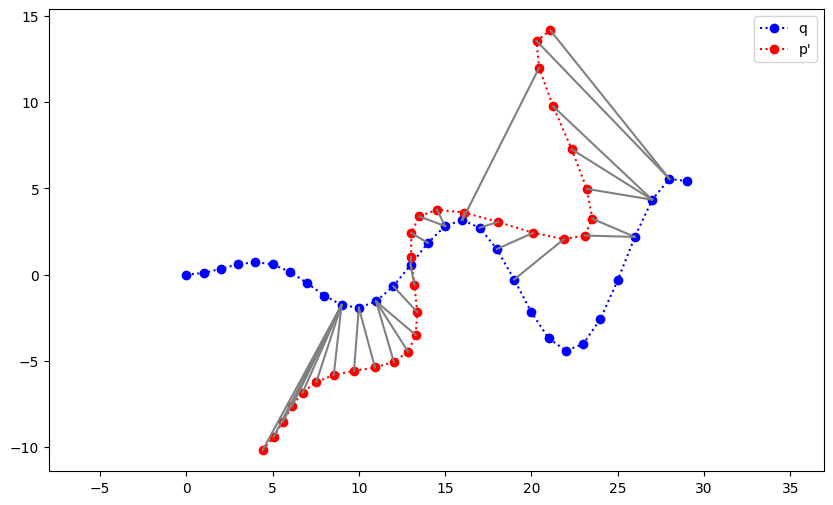

In [8]:
ax = plot_data(q, new_p, 'q', "p'")
pair = find_closest_pair(new_p, q)
draw_correspondencies(new_p, q, pair, ax)
plt.show()

In [9]:
def compute_R_t(p, q, pair, pn):
    p0 = np.zeros([2,1])
    p0[0, 0] = (p[0, :] * pn).sum() / pn.sum()
    p0[1, 0] = (p[1, :] * pn).sum() / pn.sum()

    q0 = np.zeros([2,1])
    q0[0, 0] = (q[0, :] * pn).sum() / pn.sum()
    q0[1, 0] = (q[1, :] * pn).sum() / pn.sum()

    H = np.zeros([2,2])
    for i, j in pair:
        b = q[:,j] - q0[:,0]
        a = p[:,i] - p0[:,0]
        H += np.outer(a, b) * pn[i]

    u, s, vh = np.linalg.svd(H)

    cal_R = (u @ vh).transpose()
    cal_t = q0 - cal_R @ p0

    return cal_R, cal_t

## single iteration

<AxesSubplot: >

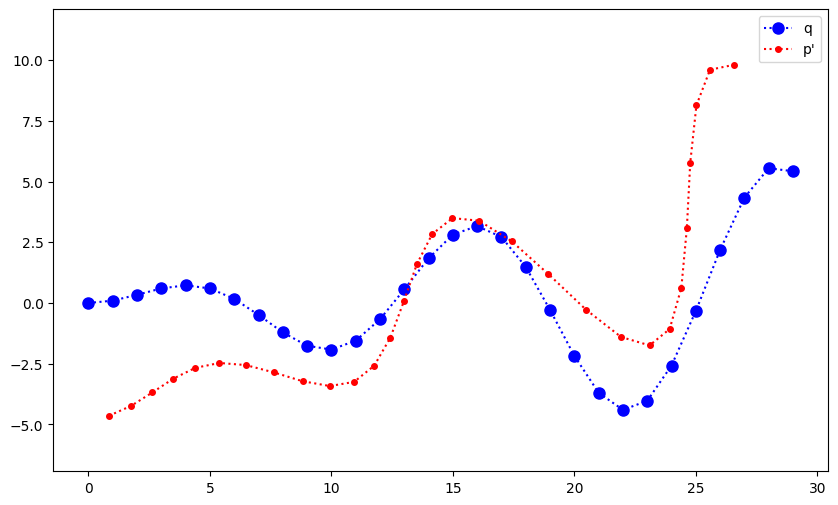

In [10]:
# equal weights pn
pn = np.ones(num)

p = centralize(p,q)
pair = find_closest_pair(p, q)

cal_R, cal_t = compute_R_t(p, q, pair, pn)
# shift p to new location
p = cal_R @ p + cal_t

plot_data(q, p, 'q', "p'", 8, 4)

## with more iteration

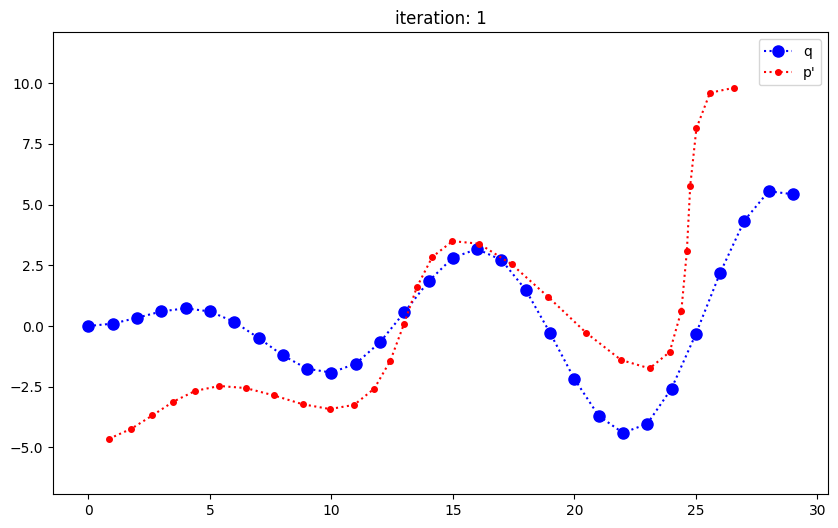

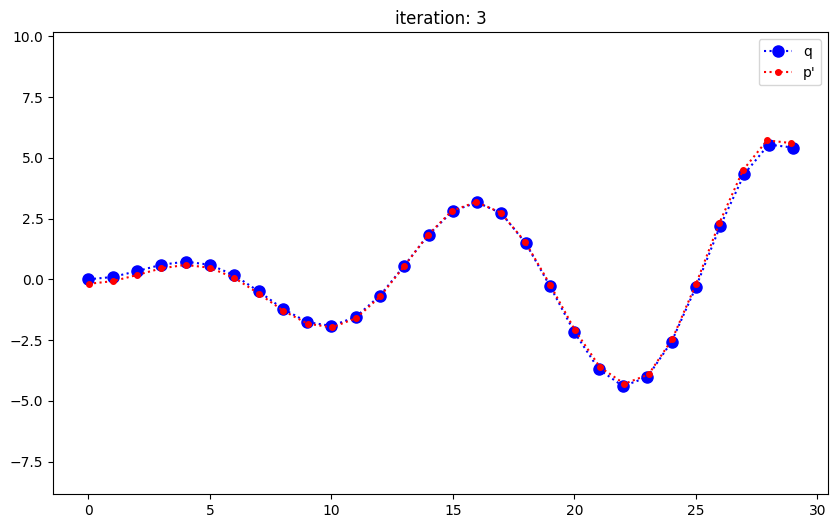

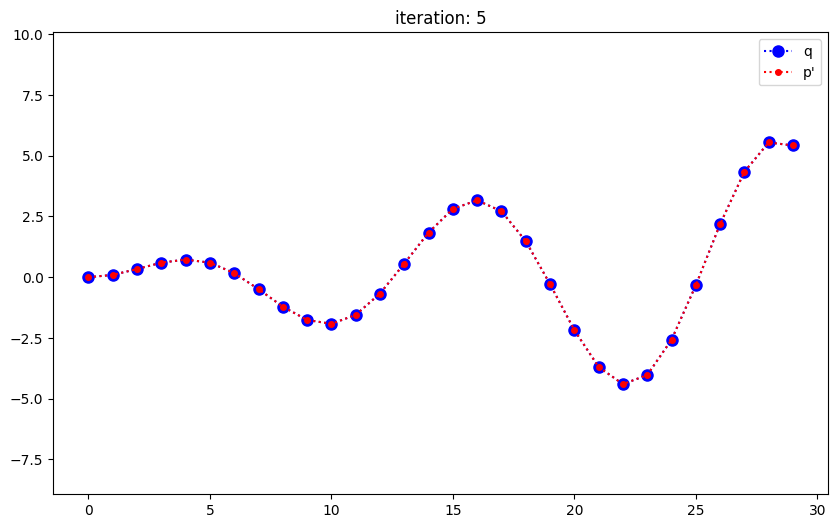

In [11]:
# generate data
num = 30
angle = np.pi / 4
R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
T = np.array([[2],[5]])

p = generate_data(num, R, T)
q = generate_data(num)

show_frame = [1, 3, 5]
# 5 is enough for convergence
for i in range(5):
    central_p = centralize(p,q)
    pair = find_closest_pair(central_p, q)

    cal_R, cal_t = compute_R_t(p, q, pair, pn)
    # shift p to new location
    p = cal_R @ p + cal_t
    
    if i+1 in show_frame:
        ax = plot_data(q, p, 'q', "p'", 8, 4)
        ax.set_title('iteration: {}'.format(i+1))
        plt.show()


# 3. non-linear least square

### point to point

In [26]:
def Jacobian(point, guess):
    tx = guess[0,0]
    ty = guess[1,0]
    theta = guess[2,0]
    J = np.zeros([2, 3])
    J[0,0] = 1
    J[1,1] = 1
    J[0,2] = -np.sin(theta) * point[0] - np.cos(theta) * point[1]
    J[1,2] = np.cos(theta) * point[0] - np.sin(theta) * point[1]
    return J

def errorVector(p, q, guess, pn):
    tx = guess[0,0]
    ty = guess[1,0]
    T = np.array([[tx],[ty]])
    theta = guess[2,0]
    R = np.array([[np.cos(theta), -np.sin(theta)],
                 [np.sin(theta), np.cos(theta)]])
    # match dimension
    xn = p.reshape([2,1])
    yn = q.reshape([2,1])
    
    error = (R @ xn + T - yn) * pn
    return error

def generate_R_t(guess):
    tx = guess[0,0]
    ty = guess[1,0]
    t = np.array([[tx],[ty]])
    theta = guess[2,0]
    R = np.array([[np.cos(theta), -np.sin(theta)],
                 [np.sin(theta), np.cos(theta)]])
    return R, t

In [27]:
def point_to_point(p, q, pair, initial_guess, pn):
    H = np.zeros([3,3])
    b = np.zeros([1,3])
    for i, j in pair:
        J = Jacobian(p[:,i], initial_guess)
        error = errorVector(p[:,i], q[:,j], initial_guess, pn[i])
        
        H += J.transpose() @ J
        b += error.transpose() @ J
    
    # -b' = H * delta_parameter
    delta = (- b @ np.linalg.inv(H)).transpose()
    
    update_guess = initial_guess + delta
    return update_guess

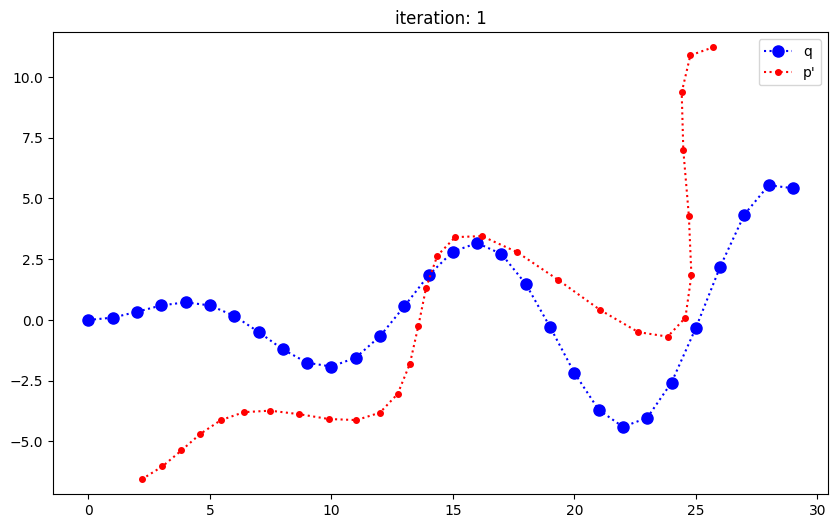

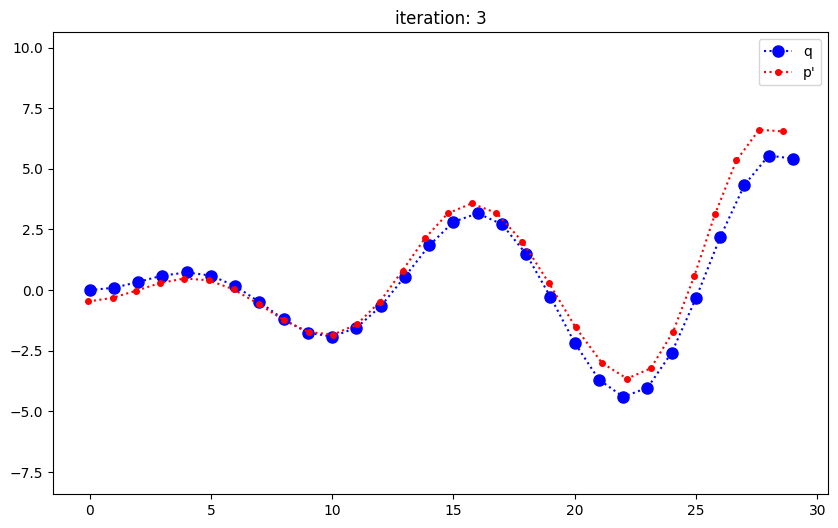

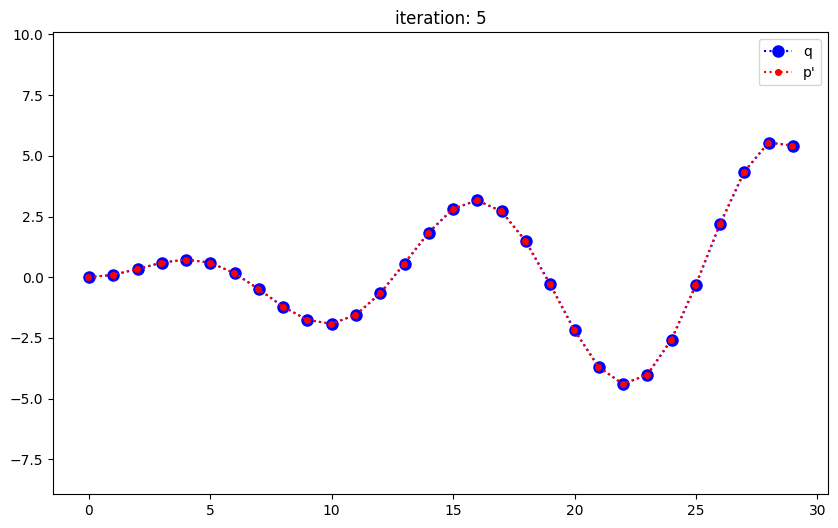

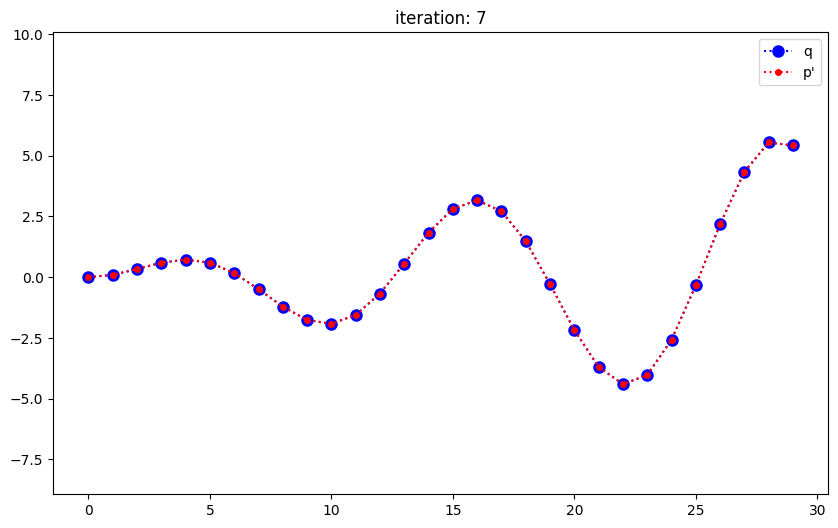

In [30]:
# equal weights pn
pn = np.ones(num)

# generate data
num = 30
angle = np.pi / 4
R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
T = np.array([[2],[5]])

p = generate_data(num, R, T)
q = generate_data(num)

initial_guess = np.array([[0.0],
                         [0.0],
                         [0.0]])

show_frame = [1, 3, 5, 7]
# 5 is enough for convergence
for i in range(7):
    central_p = centralize(p,q)
    pair = find_closest_pair(central_p, q)

    initial_guess = point_to_point(p, q, pair, initial_guess, pn)
    cal_R, cal_t = generate_R_t(initial_guess)
    # shift p to new location
    p = cal_R @ p + cal_t
    
    if i+1 in show_frame:
        ax = plot_data(q, p, 'q', "p'", 8, 4)
        ax.set_title('iteration: {}'.format(i+1))
        plt.show()

### point to plane

In [55]:
def get_normal(point):
    nx = - point[1]
    ny = point[0]
    
    if nx == 0 and ny == 0:
        return np.array([[0],[1]])
    return np.array([[nx],[ny]]) / np.sqrt(nx**2 + ny**2)

In [56]:
def Jacobian(point, guess, normal):
    tx = guess[0,0]
    ty = guess[1,0]
    theta = guess[2,0]
    dR = np.array([[-np.sin(theta), -np.cos(theta)],
                 [np.cos(theta), -np.sin(theta)]])
    J = np.zeros([1, 3])
    J[0,0] = normal[0,0]
    J[0,1] = normal[1,0]
    # match dimension
    x = point.reshape([2,1])
    J[0,2] = normal.transpose() @ dR @ x
    
    return J

def errorVector(p, q, guess, pn, normal):
    tx = guess[0,0]
    ty = guess[1,0]
    T = np.array([[tx],[ty]])
    theta = guess[2,0]
    R = np.array([[np.cos(theta), -np.sin(theta)],
                 [np.sin(theta), np.cos(theta)]])
    # match dimension
    xn = p.reshape([2,1])
    yn = q.reshape([2,1])
    
    error = (normal.transpose() @ (R @ xn + T - yn))
    return error

In [57]:
def point_to_plan(p, q, pair, initial_guess, pn):
    H = np.zeros([3,3])
    b = np.zeros([1,3])
    for i, j in pair:
        normal = get_normal(p[:,i])
        J = Jacobian(p[:,i], initial_guess, normal)
        error = errorVector(p[:,i], q[:,j], initial_guess, pn[i], normal)
        
        H += J.transpose() @ J
        b += error.transpose() @ J
    
    # -b' = H * delta_parameter
    delta = (- b @ np.linalg.inv(H)).transpose()
    
    update_guess = initial_guess + delta
    return update_guess

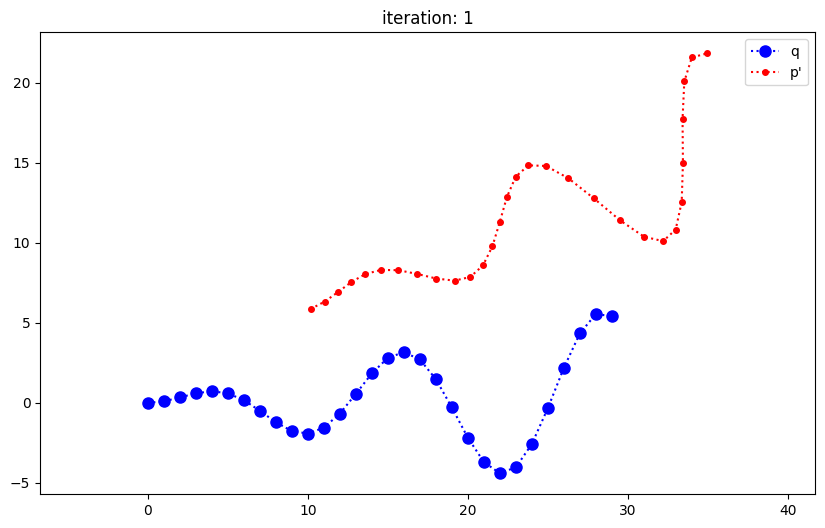

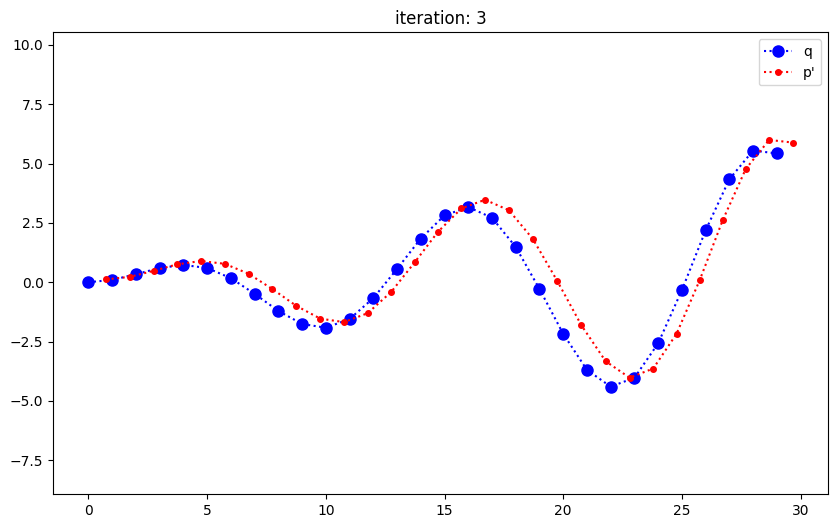

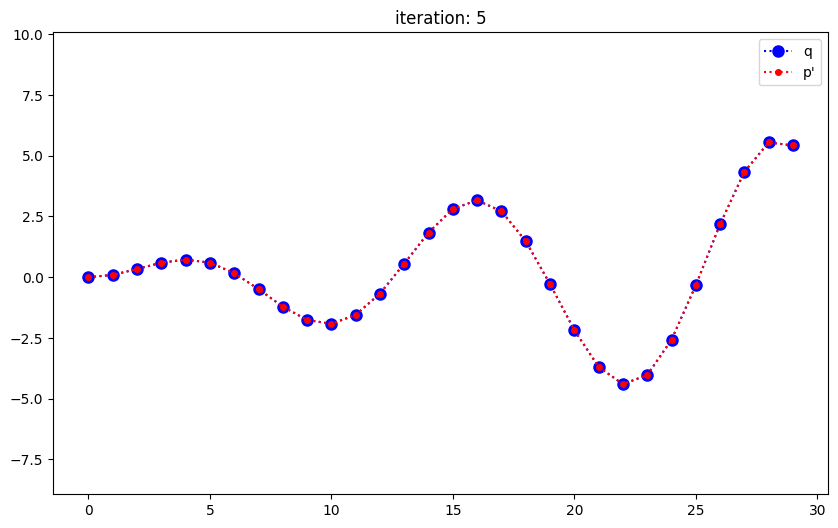

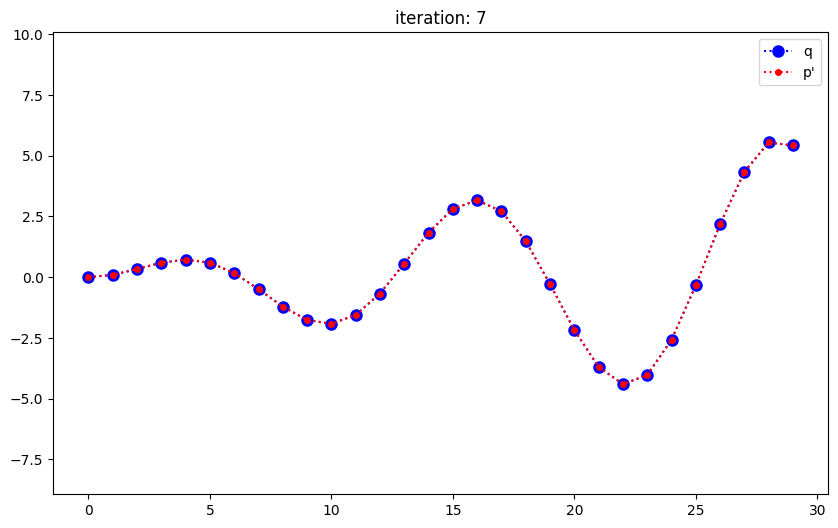

In [58]:
# equal weights pn
pn = np.ones(num)

# generate data
num = 30
angle = np.pi / 4
R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
T = np.array([[2],[5]])

p = generate_data(num, R, T)
q = generate_data(num)

initial_guess = np.array([[0.0],
                         [0.0],
                         [0.0]])

show_frame = [1, 3, 5, 7]
# 5 is enough for convergence
for i in range(7):
    central_p = centralize(p,q)
    pair = find_closest_pair(central_p, q)

    initial_guess = point_to_plan(p, q, pair, initial_guess, pn)
    cal_R, cal_t = generate_R_t(initial_guess)
    # shift p to new location
    p = cal_R @ p + cal_t
    
    if i+1 in show_frame:
        ax = plot_data(q, p, 'q', "p'", 8, 4)
        ax.set_title('iteration: {}'.format(i+1))
        plt.show()

### point to plane symmetric

In [59]:
def Jacobian(point, guess, normal1, normal2):
    tx = guess[0,0]
    ty = guess[1,0]
    theta = guess[2,0]
    dR = np.array([[-np.sin(theta), -np.cos(theta)],
                 [np.cos(theta), -np.sin(theta)]])
    J = np.zeros([1, 3])
    J[0,0] = normal1[0,0] + normal2[0,0]
    J[0,1] = normal1[1,0] + normal2[1,0]
    # match dimension
    x = point.reshape([2,1])
    J[0,2] = (normal1.transpose() @ dR @ x) + (normal2.transpose() @ dR @ x)
    
    return J

def errorVector(p, q, guess, pn, normal1, normal2):
    tx = guess[0,0]
    ty = guess[1,0]
    T = np.array([[tx],[ty]])
    theta = guess[2,0]
    R = np.array([[np.cos(theta), -np.sin(theta)],
                 [np.sin(theta), np.cos(theta)]])
    # match dimension
    xn = p.reshape([2,1])
    yn = q.reshape([2,1])
    
    error = ((normal1.transpose() + normal2.transpose()) @ (R @ xn + T - yn))
    return error

In [60]:
def point_to_plan_sym(p, q, pair, initial_guess, pn):
    H = np.zeros([3,3])
    b = np.zeros([1,3])
    for i, j in pair:
        normal1 = get_normal(p[:,i])
        normal2 = get_normal(q[:,j])
        J = Jacobian(p[:,i], initial_guess, normal1, normal2)
        error = errorVector(p[:,i], q[:,j], initial_guess, pn[i], normal1, normal2)
        
        H += J.transpose() @ J
        b += error.transpose() @ J
    
    # -b' = H * delta_parameter
    delta = (- b @ np.linalg.inv(H)).transpose()
    
    update_guess = initial_guess + delta
    return update_guess

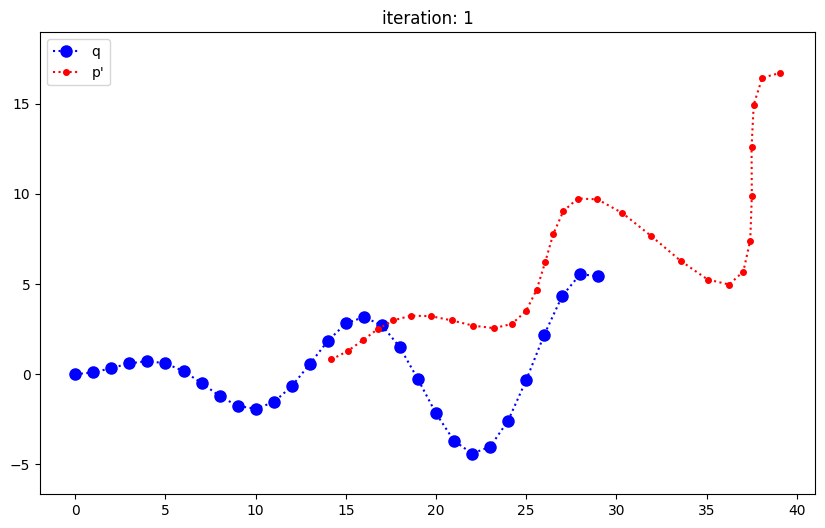

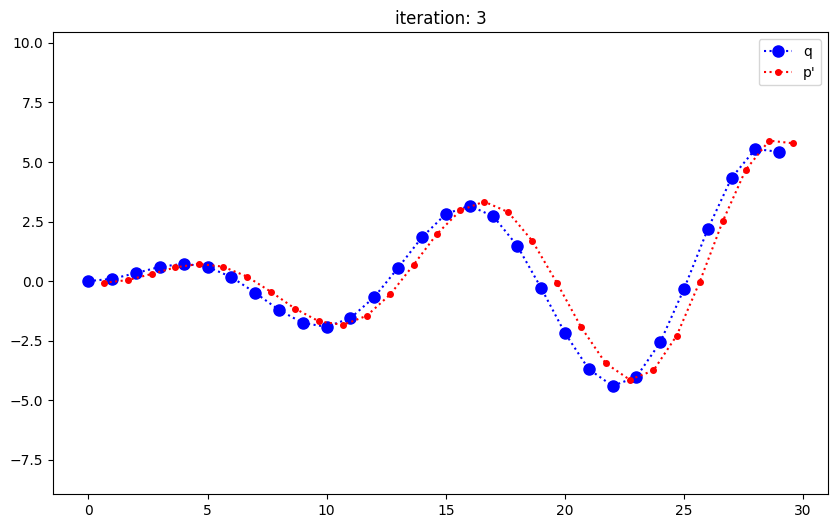

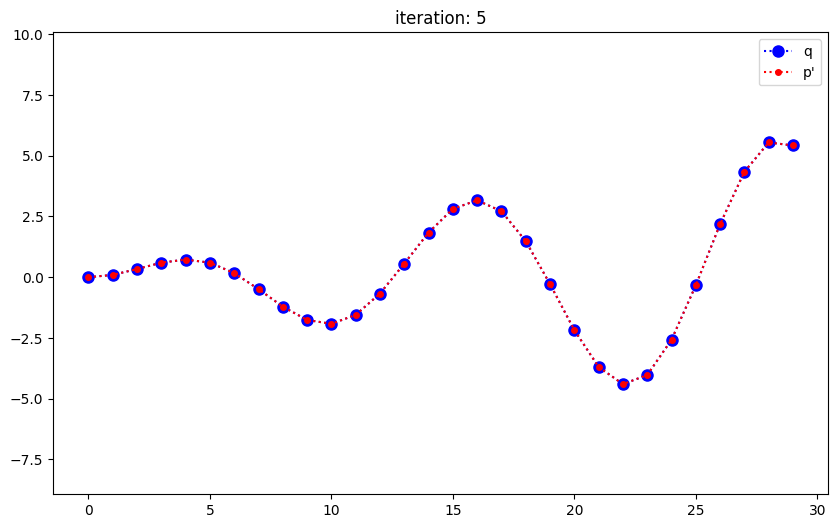

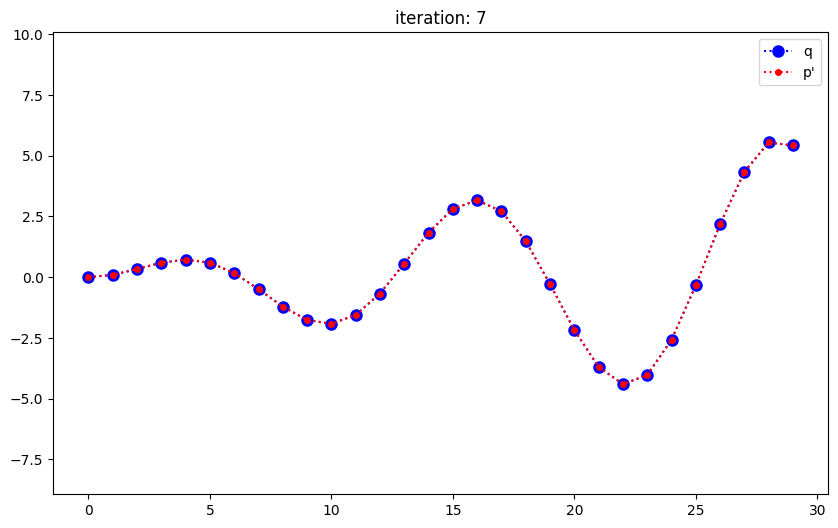

In [61]:
# equal weights pn
pn = np.ones(num)

# generate data
num = 30
angle = np.pi / 4
R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
T = np.array([[2],[5]])

p = generate_data(num, R, T)
q = generate_data(num)

initial_guess = np.array([[0.0],
                         [0.0],
                         [0.0]])

show_frame = [1, 3, 5, 7]
# 5 is enough for convergence
for i in range(7):
    central_p = centralize(p,q)
    pair = find_closest_pair(central_p, q)

    initial_guess = point_to_plan_sym(p, q, pair, initial_guess, pn)
    cal_R, cal_t = generate_R_t(initial_guess)
    # shift p to new location
    p = cal_R @ p + cal_t
    
    if i+1 in show_frame:
        ax = plot_data(q, p, 'q', "p'", 8, 4)
        ax.set_title('iteration: {}'.format(i+1))
        plt.show()